# 0. Import and data retrieval

### 1. Import & path

In [14]:
import os,sys
import pickle

from scipy.sparse import lil_matrix,save_npz, load_npz
from scipy import spatial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models.doc2vec import TaggedDocument

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RepeatedKFold

from keras.models import Sequential
from keras.layers import Dense

from pstaln.src.utils import remove_punctuation, reverse_dict

In [2]:
!ls

cord19-metadata-lang.7z					 get_language.sh
doc2vec_full_doc_50_epochs.model			 Keep_English.ipynb
doc2vec_full_doc_50_epochs.model.trainables.syn1neg.npy  Keras_CBOW.ipynb
doc2vec_full_doc_50_epochs.model.wv.vectors.npy		 pstaln
full_inferred_data.pickle				 Tests.ipynb


In [3]:
# seaborn's figure size
sns.set(rc={'figure.figsize':(15,15)})

### 2. Data reading

In [4]:
cord19_df = pd.read_feather("pstaln/data/cord19-metadata.feather")
bibliovid_df = pd.read_feather("pstaln/data/bibliovid.feather")
litcovid_df = pd.read_feather("pstaln/data/litcovid.feather")

In [5]:
# get indications of languages
cord19_lang = pd.read_json("pstaln/data/cord19-metadata-lang.json")[["title_lang","abstract_lang"]]
bibliovid_lang = pd.read_json("pstaln/data/bibliovid-lang.json")[["title_lang","abstract_lang"]]
litcovid_lang = pd.read_json("pstaln/data/litcovid-lang.json")[["title_lang","abstract_lang"]]

In [13]:
# get vocabulary dict and revert it
vocab = pickle.load(open("pstaln/data/vocab.pickle", "rb"))

rev_vocab = reverse_dict(vocab)
len(vocab)

680710

### 3. Custom functions

In [6]:
def cast_to_int(elem):
    return [int(e) for e in elem]

In [7]:
def reconstruct_sentences(list_):
    """
    return the sentence from the list of 
    """
    return [rev_vocab[elem] for elem in list_]

In [8]:
def one_hot_encode(labels_idx, idx_list):
    """
    returns the one-hot-encoding for our multilabel classification task
    to be applied to our vectorized text data
    input :
        labels_idx : list of labels index (encoding will follow the order of this variable)
        idx_list : list containing the idx of the labels for the current article
        
    """
    
    if len(idx_list)==0:
        return [-1] * len(labels_idx)
    else:
        onehotencoding = [0] * len(labels_idx)
        for elem in idx_list:
            onehotencoding[labels_idx.index(elem)] = 1
        return onehotencoding

In [9]:
def complete_sparse(row,sparse_representation):
    """
    complete the sparse representation with the number of occurence of each word in each document
    to be applied to a dataframe containing word indexes
    /!\ need to set i =0 before applying
    """
    global i
    for word_idx in row:
        sparse_representation[i,word_idx] += 1
    i+=1

# 1. Clustering using the abstracts

### 1. Preprocessing

In [10]:
# indexes for which we have title and abstract in english
bibliovid_idx = np.where((bibliovid_lang.title_lang == "en") & (bibliovid_lang.abstract_lang == "en"))[0]
litcovid_idx = np.where((litcovid_lang.title_lang == "en") & (litcovid_lang.abstract_lang == "en"))[0]
cord19_idx = np.where((cord19_lang.title_lang == "en") & (cord19_lang.abstract_lang == "en"))[0]

# select only document which have title and abstract in english
cord19_title = cord19_df.title.iloc[cord19_idx]
bibliovid_title = bibliovid_df.title.iloc[bibliovid_idx]
litcovid_title = litcovid_df.title.iloc[litcovid_idx]

# select only document which have title and abstract in english
cord19_abstract = cord19_df.abstract.iloc[cord19_idx]
bibliovid_abstract = bibliovid_df.abstract.iloc[bibliovid_idx]
litcovid_abstract = litcovid_df.abstract.iloc[litcovid_idx]

# select labels accordingly
cord19_topics = cord19_df.topics.iloc[cord19_idx]
bibliovid_topics = bibliovid_df.topics.iloc[bibliovid_idx]
litcovid_topics = litcovid_df.topics.iloc[litcovid_idx]

# concatenante our data (and cast to int type)
title_data = pd.concat([cord19_title,litcovid_title, bibliovid_title]).apply(cast_to_int).reset_index(drop=True)
abstract_data = pd.concat([cord19_abstract,litcovid_abstract, bibliovid_abstract]).apply(cast_to_int).reset_index(drop=True)
labels = pd.concat([cord19_topics,litcovid_topics,bibliovid_topics]).apply(cast_to_int).reset_index(drop=True)

In [178]:
filtering = True
if filtering:
    # drop short/empty titles (from the previous cell, we can select 5 & 10 as treshold)
    title_len = title_data.apply(len).values
    abstract_len = abstract_data.apply(len).values
    idx_to_keep = np.where((title_len>=5) & (abstract_len>=10))[0]

    labels = labels.iloc[idx_to_keep].reset_index(drop=True)
    title_data = title_data.iloc[idx_to_keep].reset_index(drop=True)
    abstract_data = abstract_data.iloc[idx_to_keep].reset_index(drop=True)

    print(title_data.shape)

(296202,)


In [104]:
# transform title and abstract into sparse array

# we create sparse array of shape = number of doc * number of words in our vocab
title_sparse_representation = lil_matrix((title_data.shape[0],len(vocab)))
abstract_sparse_representation = lil_matrix((abstract_data.shape[0],len(vocab)))

i=0
title_data.apply(lambda elem : complete_sparse(elem, title_sparse_representation))
i=0
abstract_data.apply(lambda elem : complete_sparse(elem, abstract_sparse_representation))

print("sparse transformation : ok")

sparse transformation : ok


In [179]:
# One-hot-encode our labels

#Get labels and sort the labels index
labels_values = list(set(np.concatenate(labels.loc[labels.apply(len) !=0].apply(reconstruct_sentences).values)))
print(labels_values)
labels_idx = [vocab[elem] for elem in labels_values]
labels_idx.sort()

y = labels.apply(lambda x : one_hot_encode(labels_idx, x))

['gériatrie', 'general info', 'epidémiologique', 'infectiologie', 'transmission', 'none', 'virologie', 'pronostique', 'néphrologie', 'confinement/déconfinement', 'gynécologie obstétrique', 'diagnosis', 'recommandations', 'thérapeutique', 'mechanism', 'radiologie', 'neurologie', 'case report', 'hématologie', 'hépato-gastro-entérologie', 'transversale', 'psychiatrie', 'anesthésie-réanimation', 'modélisation', 'pneumologie', 'treatment', 'diagnostique', 'cardiologie et maladies métaboliques', 'hygiène', 'immunité', 'pédiatrie', 'epidemic forecasting', 'prevention', 'autres']


In [15]:
save = False
if save :
    save_npz("pstaln/data/abstract.npz", abstract_sparse_representation.tocsr())
    save_npz("pstaln/data/title.npz", title_sparse_representation.tocsr())
    pickle.dump(y,open("pstaln/data/y.pickle","wb"))
else : 
    abstract_sparse_representation = load_npz("pstaln/data/abstract.npz").tolil()
    title_sparse_representation = load_npz("pstaln/data/title.npz").tolil()
    y = pickle.load(open("pstaln/data/y.pickle","rb") )

### 2. Word2Vec model

In [16]:
# word2vec embedding
words_title_data = title_data.apply(reconstruct_sentences)
words_abstract_data = abstract_data.apply(reconstruct_sentences)

In [117]:
# We learn the model (using both abstract and title columns).
w2v_model = gensim.models.Word2Vec(min_count=5,
                     window=4,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=7)

In [ ]:
# We build the vocab first.
w2v_model.build_vocab(words_title_data + abstract_title_data)

In [ ]:
# Then we train on titles.
w2v_model.train(words_title_data, epochs=10)

In [ ]:
# Finally we train on abstract.
w2v_model.train(words_abstract_data, epochs=20)

We wanted to try out semi-supervised learning. The Word2Vec model does not bring us any closer a labelled dataset, so we tried Doc2Vec model, which is a wrapper around Word2Vec. Doc2Vec remembers the tags of every document seen.

### 3. Doc2Vec model

####  Preprocessing

In [33]:
litcovid_title_data = litcovid_title.apply(reconstruct_sentences)
litcovid_topics_data = litcovid_topics.apply(reconstruct_sentences)
litcovid_abstract_data = litcovid_abstract.apply(reconstruct_sentences)


## The end of this cell can be used to train a model on a reduced dataset.

# # We only select the rows with topics.
litcovid_topics_mask = [(len(litcovid_topics_data.values[i])>0) for i in range(litcovid_topics_data.shape[0])]

litcovid_abstract_arr = litcovid_abstract_data.values[litcovid_topics_mask]
litcovid_topics_arr = litcovid_topics_data.values[litcovid_topics_mask]
# litcovid_title_arr = litcovid_title_data.values[litcovid_topics_mask]

# # We prepare the inputs : TaggedDocument is an object that has words & tags.
# litcovid_title_documents = \
# [TaggedDocument(doc, topics) for doc, topics  in zip(litcovid_title_arr, litcovid_topics_arr)]

litcovid_abstract_documents =\
[TaggedDocument(doc, topics) for doc, topics  in zip(litcovid_abstract_arr, litcovid_topics_arr)]

In [16]:
cord19_title_data = cord19_title.apply(reconstruct_sentences)
cord19_topics_data = cord19_topics.apply(reconstruct_sentences)
cord19_abstract_data = cord19_abstract.apply(reconstruct_sentences)


## The end of this cell can be used to train a model on a reduced dataset.

# # We only select the rows with at least one topic filled.
# cord19_topics_mask = [(len(cord19_topics_data.values[i])>0) for i in range(cord19_topics_data.shape[0])]

# cord19_title_arr = cord19_title_data.values[cord19_topics_mask]
# cord19_topics_arr = cord19_topics_data.values[cord19_topics_mask]
# cord19_abstract_arr = cord19_abstract_data.values[cord19_topics_mask]

# # We prepare the inputs : TaggedDocument is an object that has words & tags.
# cord19_title_documents = \
# [TaggedDocument(doc, topics) for doc, topics  in zip(cord19_title_arr, cord19_topics_arr)]

# cord19_abstract_documents =\
# [TaggedDocument(doc, topics) for doc, topics  in zip(cord19_abstract_arr, cord19_topics_arr)]

In [17]:
# We did not try to include bibliovid in the data, as it would add a lot more topics with very few examples.
full_abstract_data = np.concatenate((litcovid_abstract_data.values, cord19_abstract_data.values))
full_topics_data = np.concatenate((litcovid_topics_data.values, cord19_topics_data.values))

full_abstract_documents =\
[TaggedDocument(doc, topics) for doc, topics  in zip(full_abstract_data, full_topics_data)]

#### Defining and training the Doc2Vec model.

In [199]:
# Since we have a small range of documents (They all are papers about covid)
# We can afford to use vector_size = 64 for our latent space.
# If a word appears less than "min_count" times, then it is not included in the vocabulary.
# We account for "window" words left and right of the word we are focusing on (CBOW approach)

d2v_model = gensim.models.Doc2Vec(documents=full_abstract_documents,
                                  vector_size=64,
                                  window=6,
                                  min_count=3,
                                  workers=7,
                                  epochs=50)

In [572]:
# We save the model (previous cell can take up to 2hrs depending on the parameters)
d2v_model.save("doc2vec_full_doc_50_epochs.model")

# We can get rid of the training data in the model with this line,
# it reduces the memory usage but we can't train the model any further.
d2v_model.init_sims(True)

In [21]:
d2v_model = gensim.models.Doc2Vec.load("doc2vec_full_doc_50_epochs.model")

In [22]:
# How many words have we considered ? 231 164
len(d2v_model.wv.vocab)

231164

In [23]:
# What are the tags encountered in the TaggedDocuments ?
d2v_model.docvecs.doctags

{'prevention': Doctag(offset=0, word_count=3392881, doc_count=24410),
 'diagnosis': Doctag(offset=1, word_count=2208997, doc_count=12176),
 'mechanism': Doctag(offset=2, word_count=1345036, doc_count=8294),
 'treatment': Doctag(offset=3, word_count=2917355, doc_count=17259),
 'transmission': Doctag(offset=4, word_count=336703, doc_count=2067),
 'case report': Doctag(offset=5, word_count=435565, doc_count=4498),
 'epidemic forecasting': Doctag(offset=6, word_count=201445, doc_count=1037),
 'none': Doctag(offset=7, word_count=328, doc_count=2),
 'general info': Doctag(offset=8, word_count=8784, doc_count=1687)}

In [24]:
# According to the inferred_vector, the 5th document of litcovid_abstract_data is supposed
# to get the tags treatment, case report, mechanism, and diagnosis. (In descending order)
inferred_vector = d2v_model.infer_vector(litcovid_abstract_data[5], epochs=50)

for labels in d2v_model.docvecs.doctags.keys():
    print (spatial.distance.cosine(inferred_vector, d2v_model.docvecs[labels]))

1.03218474984169
0.8348368257284164
0.7355532944202423
0.6072689890861511
1.0063538467511535
0.693817526102066
1.0624209344387054
1.2459751069545746
1.0131419096142054


In [25]:
# mechanism and treatment are offset 2 & 3 respectively.
litcovid_topics_data[5]

['mechanism', 'treatment']

### First approach : Fitting a logistic regressor on the first label encountered

#### It's the easiest thing to do so we went for it.

In [203]:
## preparing document vectors for learning
def vec_for_learning_logreg(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in tagged_docs])
    return regressors, targets

In [204]:
X_logreg, y_logreg = vec_for_learning_logreg(d2v_model, litcovid_abstract_documents)

In [208]:
X_logreg_train, X_logreg_test =\
X_logreg[:len(X_logreg)*9//10], X_logreg[len(X_logreg)*9//10:]

y_logreg_train, y_logreg_test =\
y_logreg[:len(X_logreg)*9//10], y_logreg[len(X_logreg)*9//10:]

In [218]:
## training a logistic regression model
print("Training the logistic regression model...")
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
logreg.fit(X_logreg_train, y_logreg_train)

Training the logistic regression model...


LogisticRegression(max_iter=10000)

In [220]:
logreg.predict(d2v_model.infer_vector(litcovid_abstract_data[1]).reshape(1,-1))

array(['treatment'], dtype='<U20')

In [221]:
# We get terrible results. That was expected since we were supposed to predict multi-label on multi class
# But did single label on multi class instead.
logreg.score(X_logreg_test, y_logreg_test)

0.4911242603550296

In [39]:
def pred_topics(cell, log_reg_model, doc2vec_model):
    """
    predict the topic using a logistic regressor and doc2vec model
    """
    return log_reg_model.predict(doc2vec_model.infer_vector(cell).reshape(1,-1))

In [40]:
words_abstract_data[:10000].apply(lambda cell: pred_topics(cell, logreg, d2v_model))

1    10000
Name: abstract, dtype: int64

### Fitting a MLP for multi-label prediction

It's ... the 2nd easiest thing to do so we went for it as well.

In [41]:
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(100, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [42]:
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # make a prediction on the test set
        y_hat = model.predict(X_test)
        # round probabilities to class labels
        y_hat = y_hat.round()
        # calculate accuracy
        acc = f1_score(y_test, y_hat, average='weighted')
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

In [20]:
## preparing document vectors for learning
def vec_for_multi_label_learning(model, tagged_docs):
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words)) for doc in tagged_docs])
    return np.array(regressors), np.array(targets, dtype=object)

In [34]:
X_mlp, y_mlp = vec_for_multi_label_learning(d2v_model, litcovid_abstract_documents)

In [35]:
# One-hot-encode our labels
#Get labels and sort them alphabetically
labels_values = list(set(np.concatenate(y_mlp)))
labels_values.sort()
print(labels_values)

y_mlp_ohenc = np.vstack(pd.Series(y_mlp).apply(lambda x : one_hot_encode(labels_values, x)).values)

['case report', 'diagnosis', 'epidemic forecasting', 'general info', 'mechanism', 'none', 'prevention', 'transmission', 'treatment']


In [43]:
# evaluate model
results = evaluate_model(X_mlp, y_mlp_ohenc)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

>0.744


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


>0.715
>0.715
>0.711
>0.716
>0.711
>0.714
>0.716
Accuracy: 0.718 (0.010)


We get a weighted F1-Score of 0.72+-0.01, which is coherent with the performances of our fellow MedicTAL students. We now know our Doc2Vec model maps features that contain the information needed to classify the documents into the different topics.

Another test for our Doc2Vec model : are the most_similar words coherent ? We show the most_similar words to covid and disease, and get good results as well.

In [228]:
d2v_model.wv.most_similar(positive=["covid"])

[('covid-', 0.9255752563476562),
 ('covid19', 0.7221662998199463),
 ('covid-19', 0.7133566737174988),
 ('ncovid', 0.5911624431610107),
 ('covd', 0.5897005796432495),
 ('ncp', 0.5807180404663086),
 ('covid&minus', 0.5753445625305176),
 ('coivd-19', 0.5507887005805969),
 ('coronavirus-covid', 0.5499519109725952),
 ('epicovid', 0.5486166477203369)]

In [229]:
d2v_model.wv.most_similar(positive=["disease"])

[('disease.', 0.8293584585189819),
 ('diseases', 0.7921534776687622),
 ('illness', 0.7243120074272156),
 ('diseases.', 0.6665021181106567),
 ('illnesses', 0.6319650411605835),
 ('illnesses.', 0.6198300719261169),
 ('illness.', 0.6192991137504578),
 ('infection', 0.5988502502441406),
 ('hepatitis.', 0.596159815788269),
 ('disease-', 0.5897331833839417)]

It turns out we have good prediction for similarity on the words, but what about the most dissimilar words ?

We try to represent them in a 2D-graph :

In [521]:
def tsnescatterplot(model, word, list_names):
    """
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 64), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

<class 'numpy.ndarray'>
[-381.1773   -424.79688   442.40964  -197.17488  -165.5388    325.39395
 -330.22446   184.63762  -216.43613  -227.95522    50.048862  201.30528
   60.39996   241.43985   -47.361317  238.13399   106.87315    95.7841
  -46.479126  -46.222267   85.92905 ]
[  31.626696 -153.45805    63.750263   41.366184  211.3247    286.85187
  206.1411    245.43198   329.84915  -102.65206   251.18318    13.153377
   63.873104 -276.99573  -163.89555  -127.68804  -390.34515  -219.91376
 -302.4896    -24.156971  -84.640495]


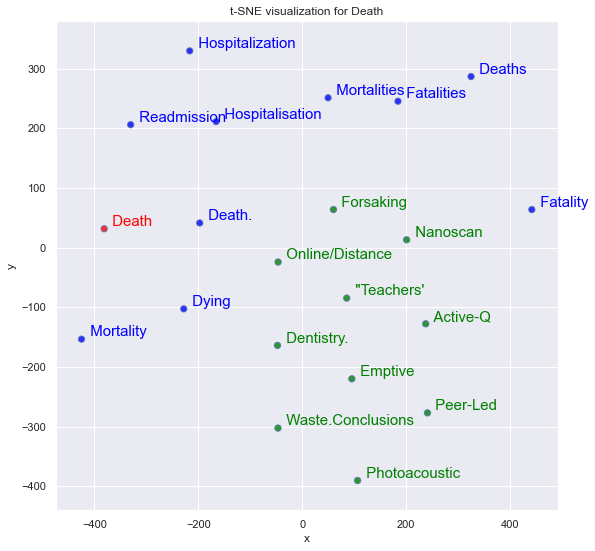

In [522]:
tsnescatterplot(d2v_model, 'death', [i[0] for i in d2v_model.wv.most_similar(negative=["death"])])

In [540]:
def tsnescatterplot_d2v(model, inferred_vector):
    """
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 64), dtype='f')
    color_list  = []

    # adds the vector of the query word
    for elt in model.docvecs.doctags.keys():
        arrays = np.append(arrays, model.docvecs[elt].reshape(1,-1), axis=0)
        color_list.append('red')

    # appends the inferred_vector
    color_list.append('blue')
    arrays = np.append(arrays, inferred_vector.reshape(1,-1), axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'tags': list(model.docvecs.doctags.keys()) + ["inferred_vector"],
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["tags"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for')

10
(10,)
10


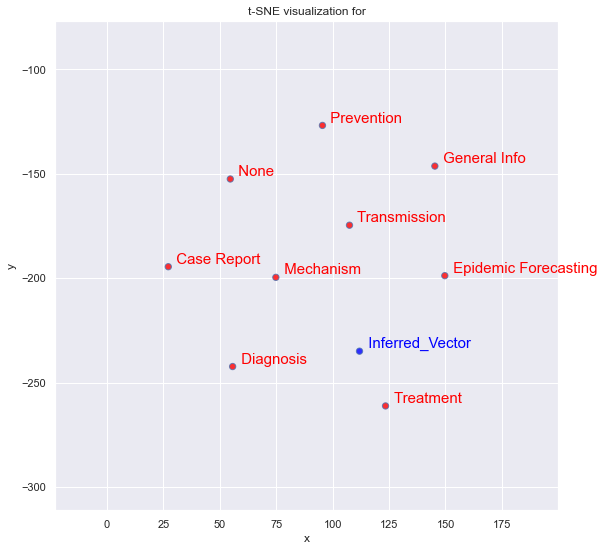

In [537]:
# Here we try to represent the tags instead of the words.
# The inferred vector is supposedly closer to :
# treatment, case report, mechanism, and diagnosis. (In descending order)
# However on this representation, it is not possible to place such a vector.
tsnescatterplot_d2v(d2v_model, d2v_model.infer_vector(litcovid_abstract_data[5], epochs=50))

In [552]:
d2v_model.docvecs.most_similar([inferred_vector])

[('treatment', 0.361937940120697),
 ('case report', 0.2807847857475281),
 ('mechanism', 0.2438260018825531),
 ('diagnosis', 0.14495405554771423),
 ('transmission', -0.01644587516784668),
 ('general info', -0.02408270165324211),
 ('prevention', -0.04816078022122383),
 ('epidemic forecasting', -0.07953976094722748),
 ('none', -0.23933632671833038)]

### Clustering using DBSCAN

We still wanted to try semi-supervised or unsupervised clustering :

In [4]:
from sklearn.cluster import DBSCAN

In [597]:
# We infer a vector for all of the data
# This operation takes 80-110 minutes.
full_inferred_data = np.vstack(pd.Series(full_abstract_data).apply(lambda x: d2v_model.infer_vector(x, epochs=50)).values)

In [ ]:
# Save the inferred data here
# pickle.dump(full_inferred_data, open("full_inferred_data.pickle", "wb"))

In [ ]:
# Load the inferred data here
full_inferred_data = pickle.load(open("full_inferred_data.pickle", "rb"))

In [598]:
full_inferred_data.shape

(427727, 64)

The clustering eats 6GB of RAM when clustering on 1/10th of the data.

We didn't have the tools to go any further on DBSCAN.

In [ ]:
clustering = DBSCAN(eps=0.05, min_samples=4, n_jobs=8).fit(full_inferred_data[:50000])

In [611]:
clustering.components_

array([[ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339],
       [ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339],
       [ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339],
       ...,
       [ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339],
       [ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339],
       [ 0.00076271,  0.00336233,  0.00160568, ..., -0.00608789,
         0.00244265, -0.00565339]], dtype=float32)

In [612]:
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
       -1,  0, -1, -1, -1

In [613]:
clustering.core_sample_indices_

array([110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 129, 130, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179,
       181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 195,
       196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 211, 212,
       213, 214, 215, 216, 217, 219, 220, 222, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       371, 373, 375, 376, 377, 378, 379, 380, 381, 383, 384, 386, 387,
       389, 390, 391, 392, 393, 394, 396, 397, 398])

In [616]:
%time  DBSCAN(eps=1, min_samples=4, n_jobs=7).fit(full_inferred_data[:50000])

CPU times: user 10min 32s, sys: 2.91 s, total: 10min 35s
Wall time: 1min 53s


DBSCAN(eps=1, min_samples=4, n_jobs=7)

### Generalization with KNN

In [44]:
from skmultilearn.adapt import MLkNN

In [72]:
def evaluate_MLkNN(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = MLkNN(k=3)
        # fit model
        model.fit(X_train, y_train)
        # make a prediction on the test set
        y_hat = model.predict(X_test)
        # round probabilities to class labels
        y_hat = y_hat.toarray()
        # calculate accuracy
        acc = f1_score(y_test, y_hat, average='weighted')
        # store result
        print('>%.3f' % acc)
        results.append(acc)
    return results

In [73]:
# evaluate MLkNN
results = evaluate_MLkNN(X_mlp, y_mlp_ohenc)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (np.mean(results), np.std(results)))

/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.681


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.665
>0.694


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.669


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.699
>0.669


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.699


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


>0.697
Accuracy: 0.684 (0.014)


/home/tcuvilliers/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
